In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

# ``` A case ```: What is wrong in simple ANNs? They are not shift invariant.

In [2]:
# Function to create images with horizontal and vertical lines
def generate_edge_image(image_size=(32, 32), edge_orientation='horizontal', position=None, noise_level=0.3):
    image = np.random.rand(*image_size) * noise_level
    
    if position is None:
        position = random.randint(0, image_size[0] - 1)
    
    if edge_orientation == 'horizontal':
        image[position, :] = 1
    elif edge_orientation == 'vertical':
        image[:, position] = 1

    return image

def generate_dataset(num_images, edge_orientation='horizontal'):
    return np.array([generate_edge_image(edge_orientation=edge_orientation) for _ in range(num_images)]), np.array([0 if edge_orientation == 'horizontal' else 1 for _ in range(num_images)])

In [3]:
# Generating training set
train_images_horizontal, train_labels_horizontal = generate_dataset(100, edge_orientation='horizontal')
train_images_vertical, train_labels_vertical = generate_dataset(100, edge_orientation='vertical')

train_images = np.concatenate([train_images_horizontal, train_images_vertical])
train_labels = np.concatenate([train_labels_horizontal, train_labels_vertical])

# Generating test set
test_images_horizontal, test_labels_horizontal = generate_dataset(50, edge_orientation='horizontal')
test_images_vertical, test_labels_vertical = generate_dataset(50, edge_orientation='vertical')

test_images = np.concatenate([test_images_horizontal, test_images_vertical])
test_labels = np.concatenate([test_labels_horizontal, test_labels_vertical])

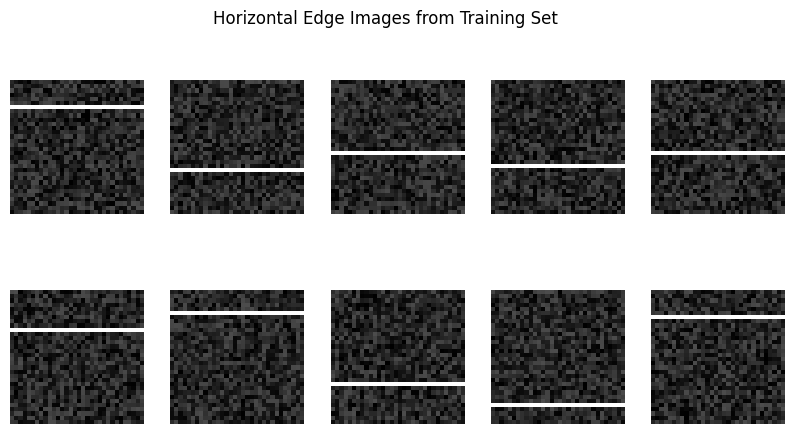

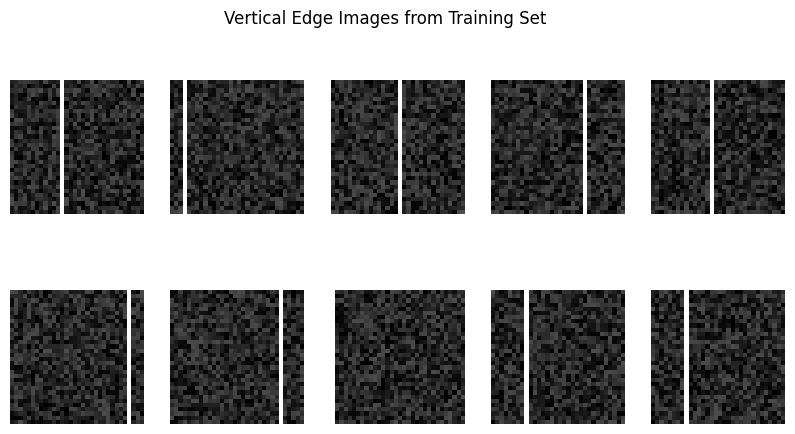

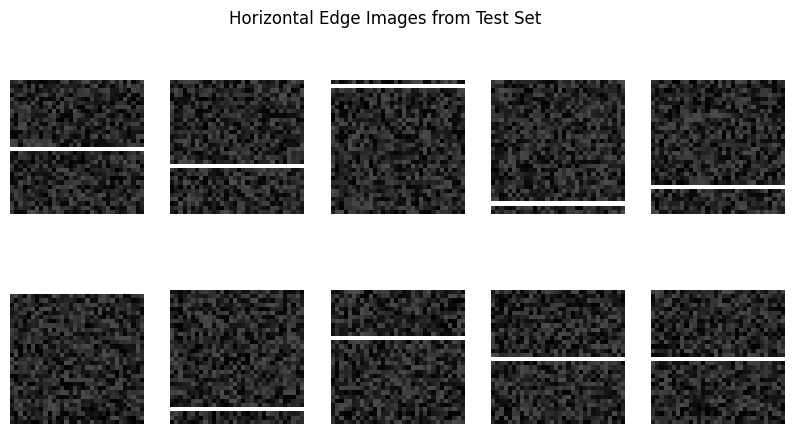

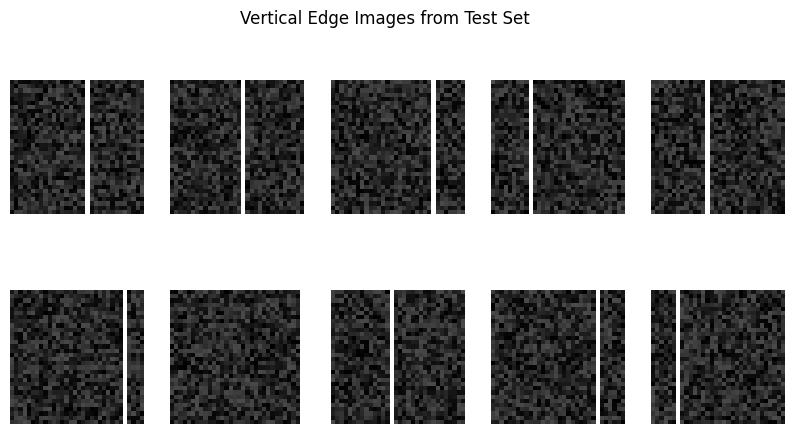

In [4]:
# Visualizing some training and test images
def show_images(images, title, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5))
    fig.suptitle(title)
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
    plt.show()

# Show some horizontal edge images from the training set
show_images(train_images_horizontal[:10], "Horizontal Edge Images from Training Set")

# Show some vertical edge images from the training set
show_images(train_images_vertical[:10], "Vertical Edge Images from Training Set")

# Show some horizontal edge images from the test set
show_images(test_images_horizontal[:10], "Horizontal Edge Images from Test Set")

# Show some vertical edge images from the test set
show_images(test_images_vertical[:10], "Vertical Edge Images from Test Set")

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [6]:
# Preparing the data
train_data = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1)
test_data = torch.tensor(test_images, dtype=torch.float32).unsqueeze(1)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

train_loader = DataLoader(TensorDataset(train_data, train_labels), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data, test_labels), batch_size=32, shuffle=False)

In [7]:
# ANN Classifier
class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.fc1 = nn.Linear(32*32, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
# Functions to train and test model
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [9]:
# Training and evaluating the ANN
ann = ANNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ann.parameters(), lr=0.001)
train_model(ann, train_loader, criterion, optimizer)
ann_accuracy = evaluate_model(ann, test_loader)
print(f'ANN Accuracy on edge test set: {ann_accuracy * 100:.2f}%')

ANN Accuracy on edge test set: 54.00%


# ``` Conclusion: ```ANNs are not good at learning patterns which are shifted in different training images (although all images have same pattern, but they are shifted).

In [10]:
# CNN Classifier
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 2)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
# Training and evaluating the CNN
cnn = CNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
train_model(cnn, train_loader, criterion, optimizer)
cnn_accuracy = evaluate_model(cnn, test_loader)
print(f'CNN Accuracy on edge test set: {cnn_accuracy * 100:.2f}%')

CNN Accuracy on edge test set: 97.00%


# ``` Observation: ``` A new variant of ANN 'CNN' succesfully classified all the images (as it scans the images instead of looking it as a whole)

### Let us see how one neuron will scan an image (the filter is just its arranged weights), neurons look for patterns in input image, and highlights if the found pattern is very correlated to pattern in filter

In [12]:
# Function to create a 20x20 image with a specific pattern
def create_image_with_pattern(shift=0):
    image = np.zeros((20, 20))
    pattern = np.array([[1, 1, 1], 
                        [0, 1, 0], 
                        [0, 1, 0]])
    
    start_row, start_col = 8 + shift, 8 + shift
    image[start_row:start_row+3, start_col:start_col+3] = pattern
    return image

In [13]:
# Create two images with the pattern shifted
image1 = create_image_with_pattern(shift=0)
image2 = create_image_with_pattern(shift=6)

In [14]:
# Define the filter (pattern to search for)/ Weights of the neuron that looks for 'T' pattern
filter_pattern = np.array([[1, 1, 1], 
                           [0, 1, 0], 
                           [0, 1, 0]])

In [15]:
# Function to scan the image and store the responses
def scan_image(image, filter_pattern):
    rows, cols = image.shape
    filter_size = filter_pattern.shape[0]
    responses = np.zeros((rows - filter_size + 1, cols - filter_size + 1))
    
    for i in range(rows - filter_size + 1):
        for j in range(cols - filter_size + 1):
            patch = image[i:i+filter_size, j:j+filter_size]
            responses[i, j] = np.sum(patch * filter_pattern)
    
    return responses

In [16]:
# Scan both images
responses1 = scan_image(image1, filter_pattern)
responses2 = scan_image(image2, filter_pattern)

# Find the maximum response in each scanned result
max_response1 = np.max(responses1)
max_response2 = np.max(responses2)

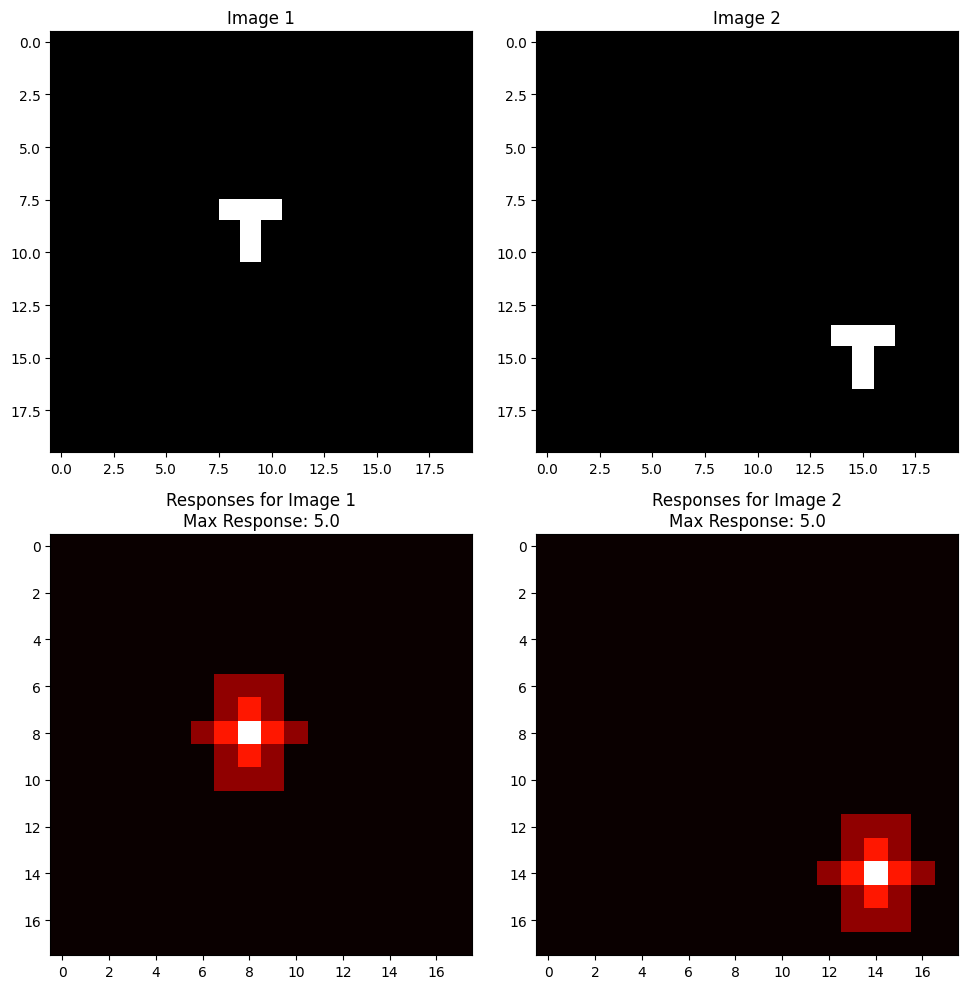

In [17]:
# Plot the images and the scanning responses
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Image 1
ax[0, 0].imshow(image1, cmap='gray')
ax[0, 0].set_title("Image 1")

# Image 2
ax[0, 1].imshow(image2, cmap='gray')
ax[0, 1].set_title("Image 2")

# Responses for Image 1
ax[1, 0].imshow(responses1, cmap='hot')
ax[1, 0].set_title(f"Responses for Image 1\nMax Response: {max_response1}")

# Responses for Image 2
ax[1, 1].imshow(responses2, cmap='hot')
ax[1, 1].set_title(f"Responses for Image 2\nMax Response: {max_response2}")

plt.tight_layout()
plt.show()

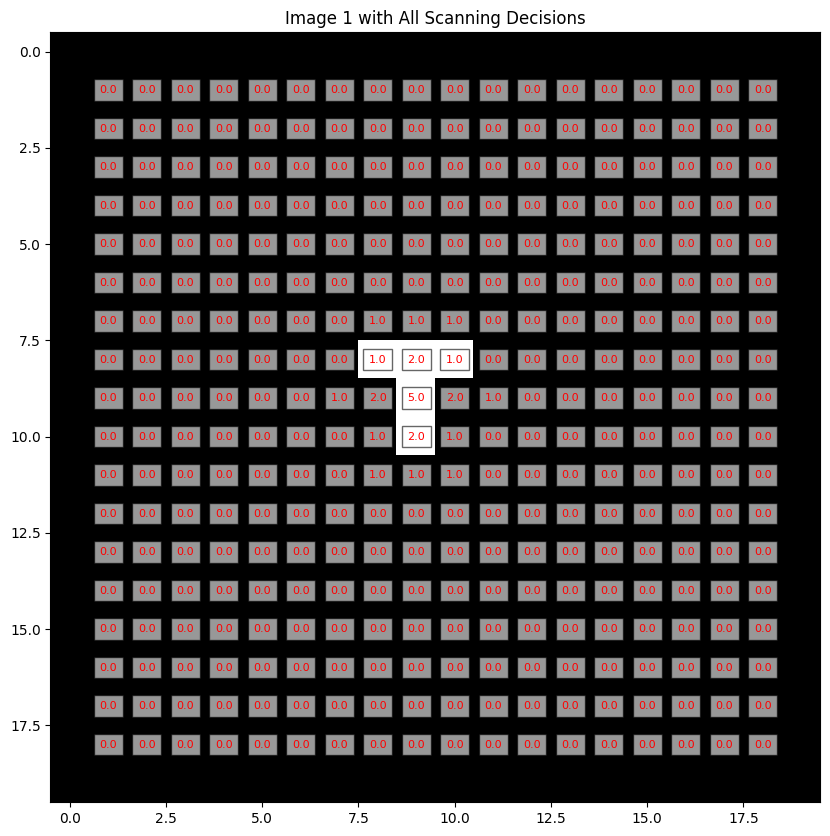

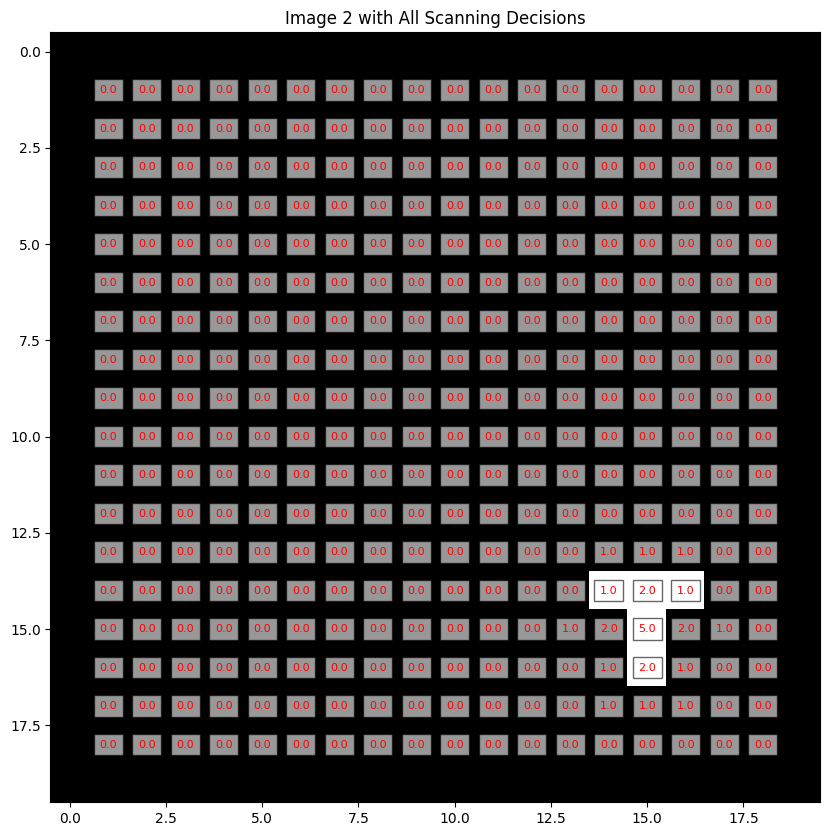

In [18]:
# Function to visualize all scanning decisions
def plot_all_decisions(image, responses, title):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    
    rows, cols = responses.shape
    for i in range(rows):
        for j in range(cols):
            ax.text(j+1, i+1, f"{responses[i, j]:.1f}", color='red', ha='center', va='center', fontsize=8, bbox=dict(facecolor='white', alpha=0.6))

# Plot all scanning decisions for both images
plot_all_decisions(image1, responses1, "Image 1 with All Scanning Decisions")
plt.show()

plot_all_decisions(image2, responses2, "Image 2 with All Scanning Decisions")
plt.show()

# ```Note:``` The response map is formally called feature map produced by that neuron. They are also images containing enriched features that the neuron was lokking for.

In [19]:
# Function to perform convolution/scanning (formally we call scanning, convolution)
def convolve(image, filter_pattern):
    rows, cols = image.shape
    filter_size = filter_pattern.shape[0]
    output = np.zeros((rows - filter_size + 1, cols - filter_size + 1))
    
    for i in range(rows - filter_size + 1):
        for j in range(cols - filter_size + 1):
            patch = image[i:i+filter_size, j:j+filter_size]
            output[i, j] = np.sum(patch * filter_pattern)
    
    return output

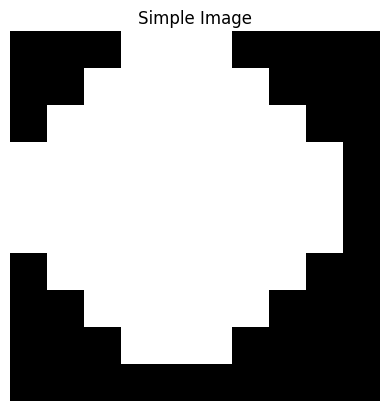

In [20]:
# Create a simple 10x10 image with a distinct pattern
simple_image = np.array([
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
])

# Plot the simple image
plt.imshow(simple_image, cmap='gray')
plt.title("Simple Image")
plt.axis('off')
plt.show()

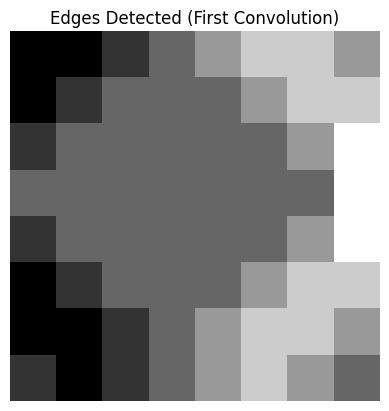

In [21]:
# Define an edge detection filter (this filter/weights of neuron will look for vertical boundaries)
edge_filter = np.array([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
])

# Apply the first convolution
edges = convolve(simple_image, edge_filter) # Scanning the original image

# Plot the edges
plt.imshow(edges, cmap='gray')
plt.title("Edges Detected (First Convolution)")
plt.axis('off')
plt.show()

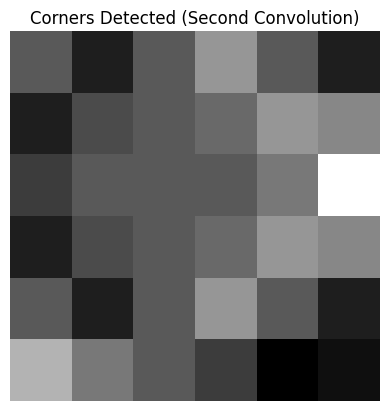

In [22]:
# Define a corner detection filter (this filter will look for corners)
corner_filter = np.array([
    [1, 1, 1],
    [1, -8, 1],
    [1, 1, 1]
])

# Apply the second convolution
corners = convolve(edges, corner_filter) # Scanning the feature map of edge filter

# Plot the corners
plt.imshow(corners, cmap='gray')
plt.title("Corners Detected (Second Convolution)")
plt.axis('off')
plt.show()

# ``` Conclusion: ```Here we performed heirarchical scanning. First we scanned the original image for low level features (e.g. edges), then we scanned the feature map produced by edge filter to look for corners. In the final feature map, the highlited black pixels represents the detection of strong corners.

# ``` Heirachical convolution once again:``` This time we take two fiters in first step, thus two finters produces two feature maps. And then scan the combination of both feature maps with a new filter. (The is like having a CNN with two neuron in first hidden layer and one neuron in next layer)

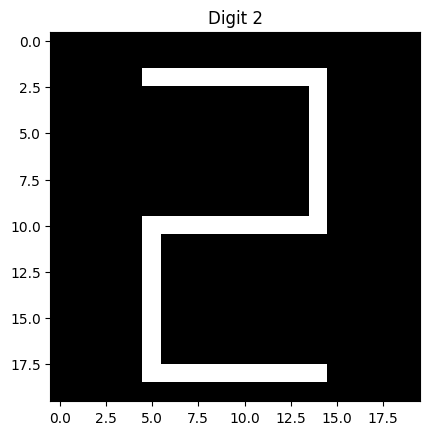

In [23]:
# Create a blank 20x20 image
image = np.zeros((20, 20))

# Draw the digit "2" on the image
# Top horizontal line
image[2, 5:15] = 1
# Middle vertical line
image[2:10, 14] = 1
# Middle horizontal line
image[10, 5:15] = 1
# Bottom vertical line
image[10:18, 5] = 1
# Bottom horizontal line
image[18, 5:15] = 1

# Plot the image
plt.imshow(image, cmap='gray')
plt.title('Digit 2')
plt.show()

In [24]:
# Define vertical edge filter
vertical_filter = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
])

# Define horizontal edge filter
horizontal_filter = np.array([
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1]
])

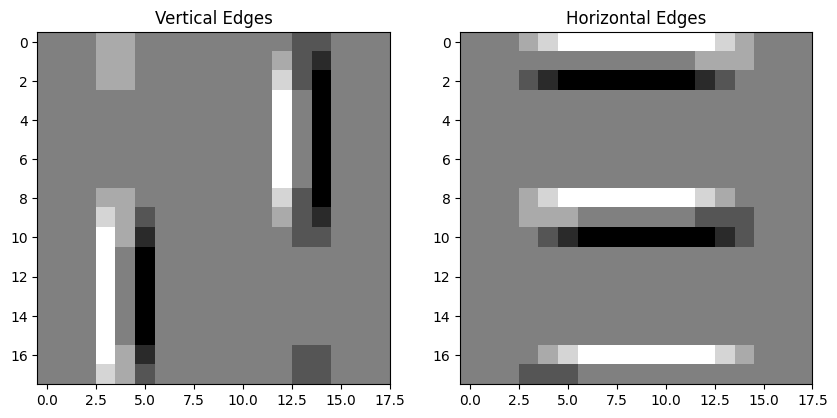

In [25]:
# Convolve the image with the vertical and horizontal filters
vertical_edges = convolve(image, vertical_filter)
horizontal_edges = convolve(image, horizontal_filter)

# Plot the feature maps
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(vertical_edges, cmap='gray')
axes[0].set_title('Vertical Edges')
axes[1].imshow(horizontal_edges, cmap='gray')
axes[1].set_title('Horizontal Edges')
plt.show()

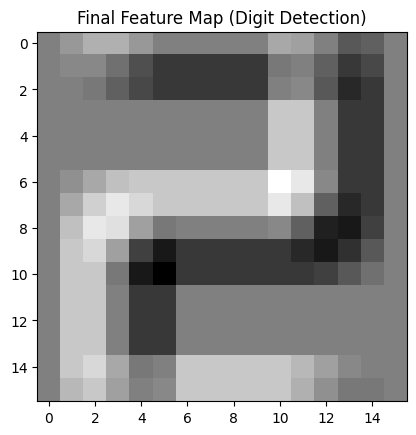

In [26]:
# Define a simple digit detection filter (for demonstration purpose)
digit_filter = np.ones((3, 3))

# Combine the feature maps using the digit filter
combined_feature_map = convolve(vertical_edges + horizontal_edges, digit_filter) # Scanning the combination of previous two feature maps

# Plot the final feature map
plt.imshow(combined_feature_map, cmap='gray')
plt.title('Final Feature Map (Digit Detection)')
plt.show()

# ```What next: ``` Once we recieve enriched feature maps from CNN, we use a max operation or a whole new ANN to take decisions(Usually we use simple ANNs)

In [27]:
# Flatten the feature map (Since ANNs can take only 1D vectors)
flattened_feature_map = combined_feature_map.flatten()
print(flattened_feature_map.shape)  # Should be a 1D array

(256,)


In [28]:
import torch.nn.functional as F

# Simulate a fully connected layer
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(flattened_feature_map.size, 10)  # 10 output neurons for digits 0-9

    def forward(self, x):
        x = self.fc1(x)
        return F.softmax(x, dim=0)

# Instantiate the model
model = SimpleNN()

# Convert the feature map to a tensor
input_tensor = torch.tensor(flattened_feature_map, dtype=torch.float32)

# Make a prediction
output = model(input_tensor)
predicted_class = torch.argmax(output).item()

print(f'Predicted class: {predicted_class}')

Predicted class: 5


# ```Conclusion: ```First we scan the raw image in a heirarchical way and finally process the final feature map (as we did in digit classifier) to take decisions. This final model can be tweaked to perform regression or classifical, but convolutional layers will always remain same, their job is to produce a rich representation of original image.
### In this case our ANN is misclassifying the digit 2, as it is untrained model (Here I have just put the ANN code to show that how we complete a CNN model, convolutional layers (feature extraction) + simple fully connected layes(performing classification or regression))